# evaluating the first graph reg models

In [1]:
import sys
sys.path.append('/data/leslie/sarthak/caduceus/')
from src.models.sequence.dna_embedding import DNAEmbeddingModelCaduceus
from src.tasks.decoders import GraphRegDecoder
from caduceus.configuration_caduceus import CaduceusConfig
import torch
import numpy as np
import src.dataloaders.datasets.graphreg_dataset as d
import yaml
from omegaconf import OmegaConf
import os
# import matplotlib.pyplot as plt
# import seaborn as sns
from tqdm import tqdm

ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2024-11-22/14-55-44-292356/checkpoints/07-val_loss=0.65637.ckpt'
split = 'test'

try:
    OmegaConf.register_new_resolver('eval', eval)
    OmegaConf.register_new_resolver('div_up', lambda x, y: (x + y - 1) // y)
except ValueError as e:
    if "Resolver already registered" in str(e):
            print("Resolver already exists, skipping registration.")

#making some tests for the evaluation
model_cfg_path = os.path.join(os.path.dirname(os.path.dirname(ckpt_path)), '.hydra', 'config.yaml')
cfg = yaml.load(open(model_cfg_path, 'r'), Loader=yaml.FullLoader)
cfg = OmegaConf.create(cfg)
cfg = OmegaConf.to_container(cfg, resolve=True)
state_dict = torch.load(ckpt_path, map_location='cpu')
dataset_args = cfg['dataset']
dataset = d.GraphRegDataset(split, dataset_args['max_length'], rc_aug = dataset_args['rc_aug'],
                                                            cell_type=dataset_args.get('cell_type', None),
                                                            kmer_len=dataset_args.get('kmer_len', None),
                                                            remove_repeats=dataset_args.get('remove_repeats', False),
                                                            has_TSS=dataset_args.get('has_TSS', False),
                                                            clean_data=dataset_args.get('clean_data', True),
                                                            vocab_size=cfg['model']['config']['vocab_size'],)

torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)
model_state_dict = state_dict["state_dict"]
# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)
# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
for key in list(model_state_dict.keys()):
    if "decoder" in key:
        decoder_state_dict[key[10:]] = model_state_dict.pop(key)
encoder_state_dict = {}
for key in list(model_state_dict.keys()):
    if "encoder" in key:
        encoder_state_dict[key[10:]] = model_state_dict.pop(key)

cfg['model']['config'].pop('_target_')
cfg['model']['config']['complement_map'] = dataset.tokenizer.complement_map
caduceus_cfg = CaduceusConfig(**cfg['model']['config'])
print(caduceus_cfg)
# self.backbone = DNAEmbeddingModelCaduceus(config=caduceus_cfg)

base_path: /data1/lesliec/sarthak/
CaduceusConfig {
  "bidirectional": true,
  "bidirectional_strategy": "add",
  "bidirectional_weight_tie": true,
  "complement_map": {
    "0": 0,
    "1": 1,
    "10": 7,
    "11": 11,
    "2": 2,
    "3": 3,
    "4": 4,
    "5": 5,
    "6": 6,
    "7": 10,
    "8": 9,
    "9": 8
  },
  "d_model": 128,
  "fused_add_norm": true,
  "initializer_cfg": {
    "initializer_range": 0.02,
    "n_residuals_per_layer": 1,
    "rescale_prenorm_residual": true
  },
  "model_type": "caduceus",
  "n_layer": 8,
  "norm_epsilon": 1e-05,
  "pad_vocab_size_multiple": 1,
  "rcps": true,
  "residual_in_fp32": false,
  "rms_norm": true,
  "ssm_cfg": {
    "bias": false,
    "conv_bias": true,
    "d_conv": 4,
    "d_state": 16,
    "dt_init": "random",
    "dt_init_floor": 0.0001,
    "dt_max": 0.1,
    "dt_min": 0.001,
    "dt_rank": "auto",
    "dt_scale": 1.0,
    "expand": 2,
    "use_fast_path": true
  },
  "transformers_version": "4.38.1",
  "vocab_size": 12
}



In [8]:
cfg

{'train': {'seed': 2222,
  'interval': 'epoch',
  'monitor': 'val/loss',
  'mode': 'min',
  'ema': 0.0,
  'test': True,
  'debug': False,
  'ignore_warnings': False,
  'optimizer_param_grouping': {'bias_weight_decay': False,
   'normalization_weight_decay': False},
  'state': {'mode': None, 'n_context': 0, 'n_context_eval': 0},
  'ckpt': 'checkpoints/last.ckpt',
  'disable_dataset': False,
  'validate_at_start': False,
  'pretrained_model_path': None,
  'pretrained_model_strict_load': True,
  'pretrained_model_state_hook': {'_name_': None},
  'post_init_hook': {'_name_': None},
  'layer_decay': {'_name_': None, 'decay': 0.7},
  'gpu_mem': 46,
  'global_batch_size': 1},
 'wandb': {'project': 'dna',
  'group': 'graphreg',
  'job_type': 'training',
  'mode': 'online',
  'name': 'GR_1M',
  'save_dir': '.',
  'id': 'GR_1M'},
 'trainer': {'_target_': 'pytorch_lightning.Trainer',
  'devices': 1,
  'accelerator': 'gpu',
  'accumulate_grad_batches': 8,
  'max_epochs': 1000,
  'gradient_clip_val

In [7]:
dataset_args

{'_name_': 'GraphRegLoader',
 'bed_file': None,
 'fasta_file': None,
 'dataset_name': 'GraphRegLoader',
 'tokenizer_name': 'char',
 'cache_dir': None,
 'max_length': 1000000,
 'add_eos': False,
 'batch_size': 1,
 'batch_size_eval': 2,
 'num_workers': 4,
 'shuffle': True,
 'pin_memory': True,
 '__train_len': 1000,
 '__l_max': 1000000,
 'max_length_val': 1000000,
 'max_length_test': 1000000,
 'pad_max_length': None,
 'rc_aug': False,
 'use_fixed_len_val': False,
 'replace_N_token': False,
 'pad_interval': False,
 'kmer_len': None,
 'cell_type': 'GM12878',
 'mlm': False}

In [2]:
backbone = DNAEmbeddingModelCaduceus(config=caduceus_cfg)
backbone

DNAEmbeddingModelCaduceus(
  (caduceus): Caduceus(
    (backbone): CaduceusMixerModel(
      (embeddings): CaduceusEmbeddings(
        (word_embeddings): RCPSEmbedding(
          (embedding): Embedding(12, 128)
        )
      )
      (layers): ModuleList(
        (0-7): 8 x RCPSMambaBlock(
          (mixer): RCPSWrapper(
            (submodule): BiMambaWrapper(
              (mamba_fwd): Mamba(
                (in_proj): Linear(in_features=128, out_features=512, bias=False)
                (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
                (act): SiLU()
                (x_proj): Linear(in_features=256, out_features=40, bias=False)
                (dt_proj): Linear(in_features=8, out_features=256, bias=True)
                (out_proj): Linear(in_features=256, out_features=128, bias=False)
              )
              (mamba_rev): Mamba(
                (in_proj): Linear(in_features=128, out_features=512, bias=False)
                (con

In [3]:
dataset.tokenizer.complement_map

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 10,
 '8': 9,
 '9': 8,
 '10': 7,
 '11': 11}

In [4]:
backbone.load_state_dict(model_state_dict, strict=True) #ah it's an issue with the complement array being a different size, I shrunk it down to 12 too!

<All keys matched successfully>

In [5]:
import evals.evals_utils_graphreg as g
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2024-11-22/14-55-44-292356/checkpoints/07-val_loss=0.65637.ckpt'
evals = g.Evals(ckpt_path)

RuntimeError: Error(s) in loading state_dict for DNAEmbeddingModelCaduceus:
	size mismatch for caduceus.backbone.embeddings.word_embeddings.complement_map: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([16]).

In [1]:
#need to restart it, let's check what the complement map is and if it's correct!
import evals.evals_utils_graphreg as g
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2024-11-22/14-55-44-292356/checkpoints/07-val_loss=0.65637.ckpt'
evals = g.Evals(ckpt_path)

base_path: /data1/lesliec/sarthak/


In [4]:
evals.backbone.caduceus.backbone.embeddings.word_embeddings.complement_map #ok this is correct, so the training is fine

tensor([ 0,  1,  2,  3,  4,  5,  6, 10,  9,  8,  7, 11], device='cuda:0')

In [5]:
out = evals(0)
out.shape

torch.Size([1, 10000, 3])

In [6]:
results = evals.evaluate(batch_size=1)

  0%|          | 0/823 [00:00<?, ?it/s]


AttributeError: 'list' object has no attribute 'to'

In [7]:
data = evals.dataset[0]
data[0].shape

torch.Size([1000000])

In [16]:
import torch
loader = torch.utils.data.DataLoader(evals.dataset, batch_size=3, shuffle=False)
loader = iter(loader)
data = next(loader)
len(data)

2

In [18]:
print(data[0].shape) #yeah seems right
print(data[1].shape) #also seems right...
#oh we forgot that in the altered enformer dataset doesn't return anything, we now need to specify it's the 0 element!!

torch.Size([3, 1000000])
torch.Size([3, 10000, 3])


# proper evaluation now

In [1]:
import evals.evals_utils_graphreg as g
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2024-11-22/14-55-44-292356/checkpoints/07-val_loss=0.65637.ckpt'
evals = g.Evals(ckpt_path)

base_path: /data1/lesliec/sarthak/


In [2]:
results = evals.evaluate(batch_size=3) #uses roughly 44GB with 3, and on A40 no more space!

  0%|          | 0/275 [00:00<?, ?it/s]

100%|██████████| 275/275 [27:08<00:00,  5.92s/it]


In [4]:
print(results.shape)
print(results.nbytes/1e9)

(823, 10000, 3)
0.04938


In [6]:
#let's save it out in data
import numpy as np
np.save('/data1/lesliec/sarthak/data/GraphReg/model_out/1M_model_11-25', results)

In [3]:
#let's load in the results of the models and compare to the true
import numpy as np
import evals.evals_utils_graphreg as g
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2024-11-22/14-55-44-292356/checkpoints/07-val_loss=0.65637.ckpt'
evals = g.Evals(ckpt_path)
results = np.load('/data1/lesliec/sarthak/data/GraphReg/model_out/1M_model_11-25.npy')
print(len(evals.dataset),results.shape)

base_path: /data1/lesliec/sarthak/
823 (823, 10000, 3)


In [5]:
#let's plot a random example
import matplotlib.pyplot as plt
#look at example 800
true = evals.dataset[400][1].numpy()
pred = results[400]
print(true.shape, pred.shape)

(10000, 3) (10000, 3)


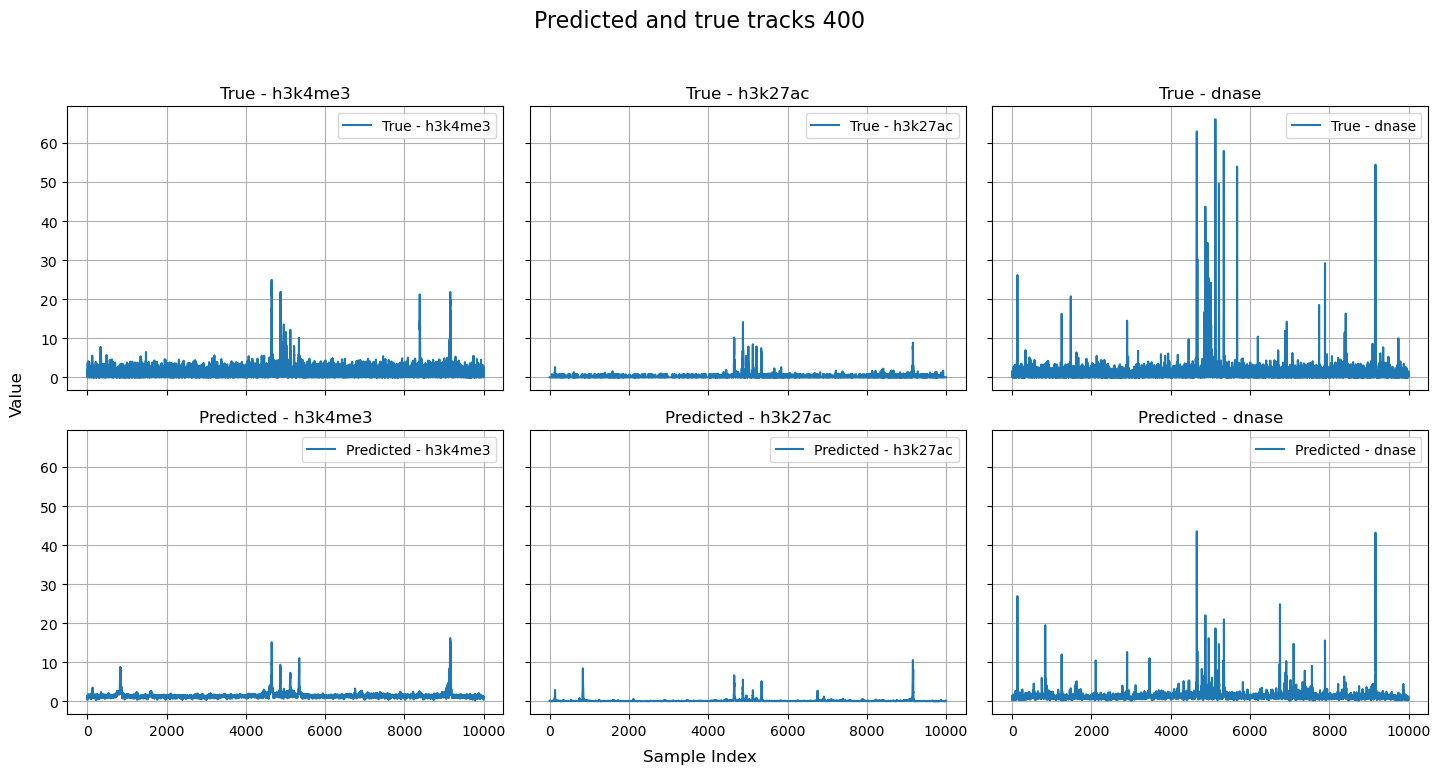

In [8]:
#now make a 2x3
idx = 400
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)

# Titles for rows and columns
row_titles = ['True', 'Predicted']
col_titles = ['h3k4me3', 'h3k27ac', 'dnase']

# Populate the subplots
for row, data in enumerate([true, pred]):
    for col in range(3):
        ax = axes[row, col]
        ax.plot(data[:, col], label=f'{row_titles[row]} - {col_titles[col]}')
        ax.set_title(f'{row_titles[row]} - {col_titles[col]}')
        ax.legend()
        ax.grid(True)

# Add shared labels
fig.suptitle(f'Predicted and true tracks {idx}', fontsize=16)
fig.text(0.5, 0.04, 'Sample Index', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Value', va='center', rotation='vertical', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

# Show the plot
plt.show()

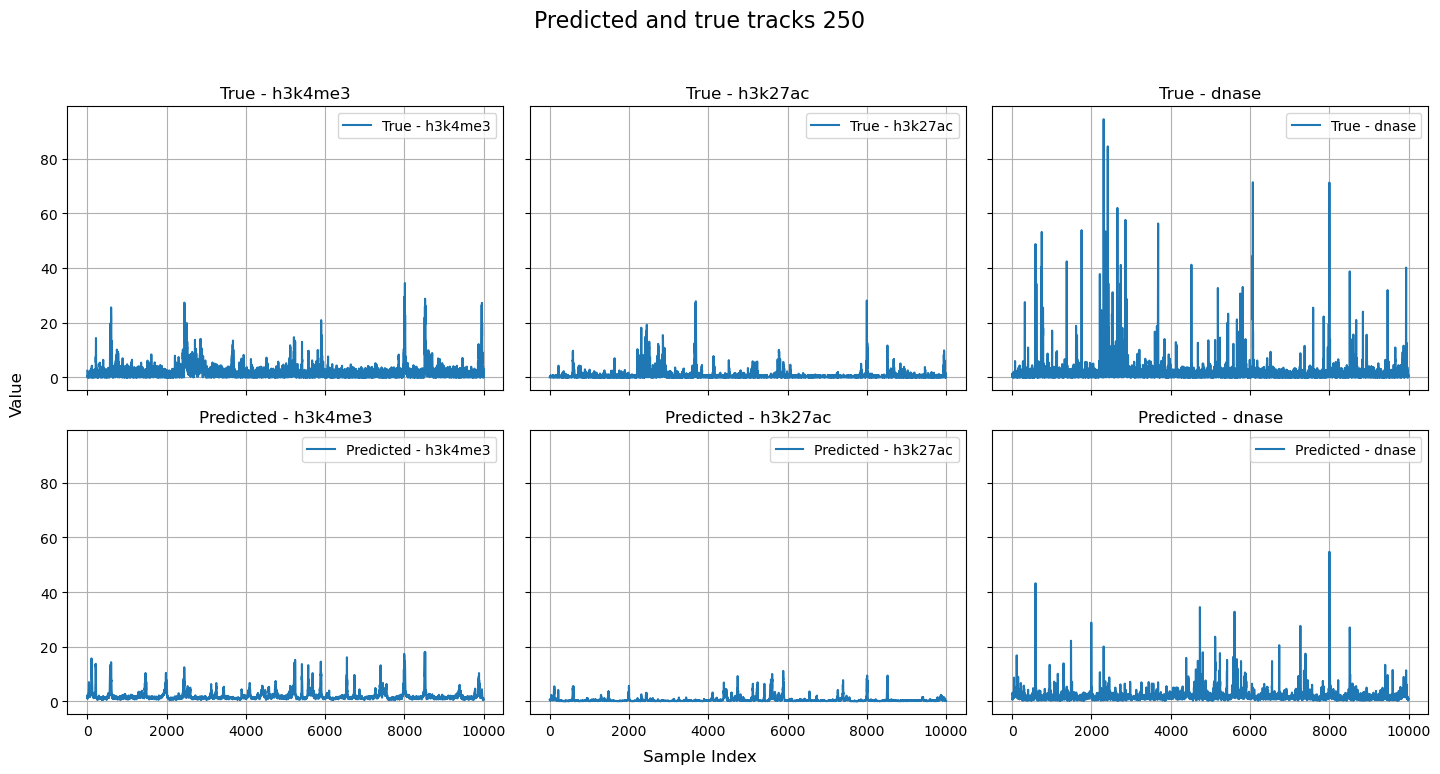

In [9]:
idx = 250
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)

true = evals.dataset[idx][1].numpy()
pred = results[idx]

# Titles for rows and columns
row_titles = ['True', 'Predicted']
col_titles = ['h3k4me3', 'h3k27ac', 'dnase']

# Populate the subplots
for row, data in enumerate([true, pred]):
    for col in range(3):
        ax = axes[row, col]
        ax.plot(data[:, col], label=f'{row_titles[row]} - {col_titles[col]}')
        ax.set_title(f'{row_titles[row]} - {col_titles[col]}')
        ax.legend()
        ax.grid(True)

# Add shared labels
fig.suptitle(f'Predicted and true tracks {idx}', fontsize=16)
fig.text(0.5, 0.04, 'Sample Index', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Value', va='center', rotation='vertical', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

# Show the plot
plt.show()

In [11]:
#let's actually calculate pearson correlation over every sample
from scipy.stats import pearsonr
from tqdm import tqdm
corrs_me3 = []
corrs_ac = []
corrs_dnase = []
for i in tqdm(range(len(results))):
    true = evals.dataset[i][1].numpy()
    pred = results[i]
    corrs_me3.append(pearsonr(true[:,0], pred[:,0])[0])
    corrs_ac.append(pearsonr(true[:,1], pred[:,1])[0])
    corrs_dnase.append(pearsonr(true[:,2], pred[:,2])[0])


100%|██████████| 823/823 [00:02<00:00, 369.84it/s]


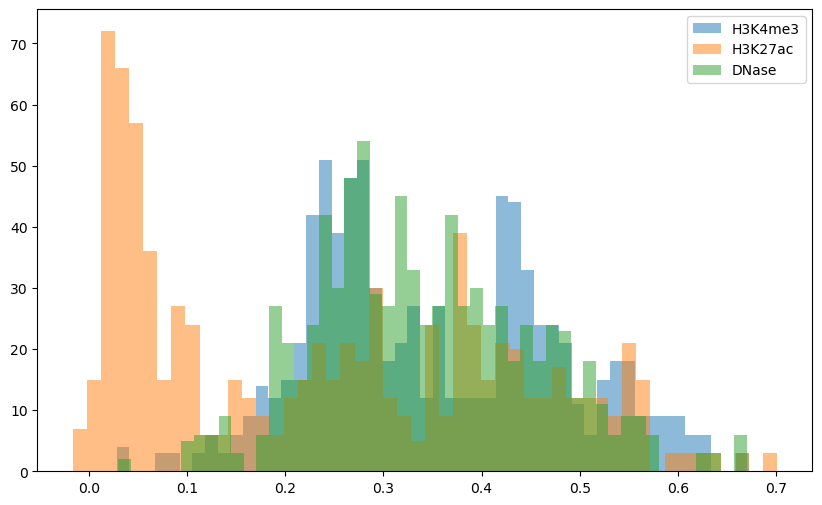

In [12]:
#and now plot them with different colors
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(corrs_me3, bins=50, alpha=0.5, label='H3K4me3')
ax.hist(corrs_ac, bins=50, alpha=0.5, label='H3K27ac')
ax.hist(corrs_dnase, bins=50, alpha=0.5, label='DNase')
ax.legend()
plt.show()

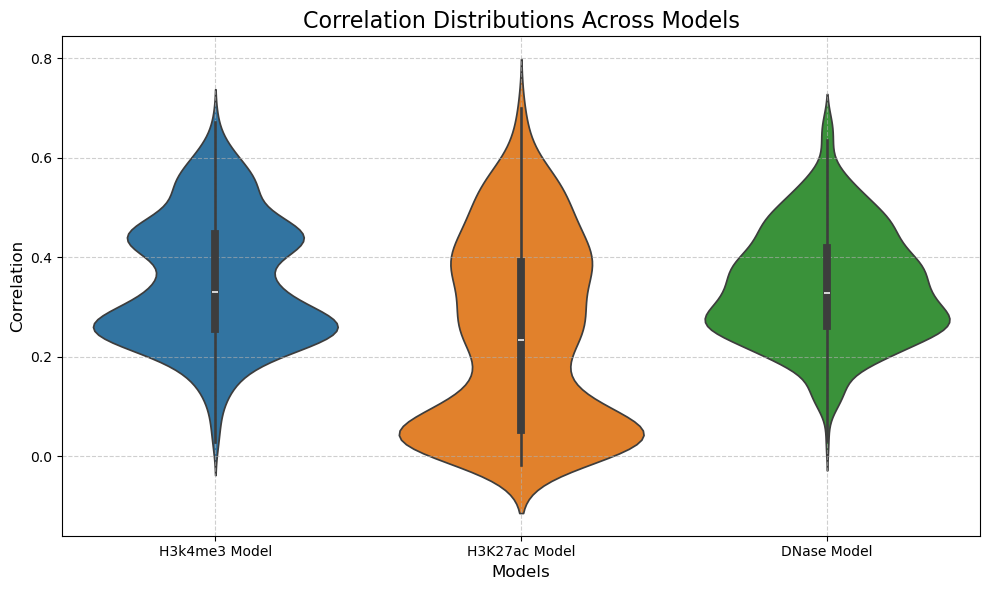

In [16]:
import seaborn as sns

data = [corrs_me3, corrs_ac, corrs_dnase]
labels = ['H3k4me3 Model', 'H3K27ac Model', 'DNase Model']

# Create a figure and axis for the plot
plt.figure(figsize=(10, 6))

# Plot the violin plot
sns.violinplot(data=data)

# Set custom x-tick labels
plt.xticks(ticks=[0, 1, 2], labels=labels)

# Add titles and labels
plt.title('Correlation Distributions Across Models', fontsize=16)
plt.ylabel('Correlation', fontsize=12)
plt.xlabel('Models', fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

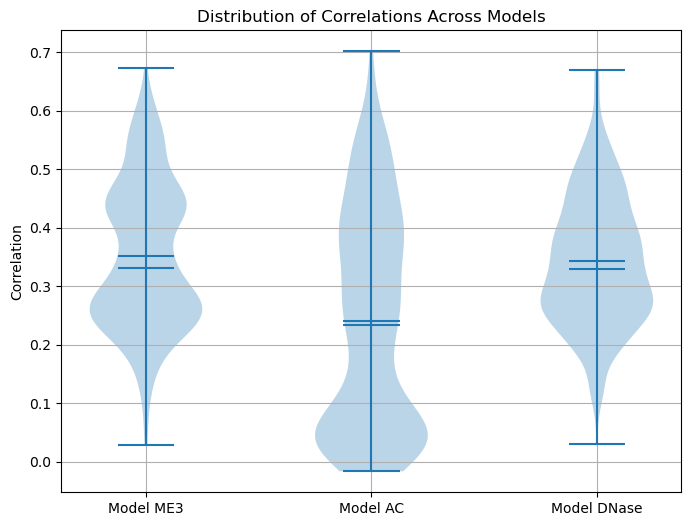

In [17]:
data = [corrs_me3, corrs_ac, corrs_dnase]
labels = ['Model ME3', 'Model AC', 'Model DNase']

# Create the violin plot
plt.figure(figsize=(8, 6))
plt.violinplot(data, showmeans=True, showmedians=True, showextrema=True)

# Add labels and title
plt.xticks([1, 2, 3], labels)
plt.ylabel('Correlation')
plt.title('Distribution of Correlations Across Models')
plt.grid(True)

# Show the plot
plt.show()

In [18]:
#and check it on some train data
evals_train = g.Evals(ckpt_path, split='train')

torch.Size([10000, 3]) torch.Size([10000, 3])


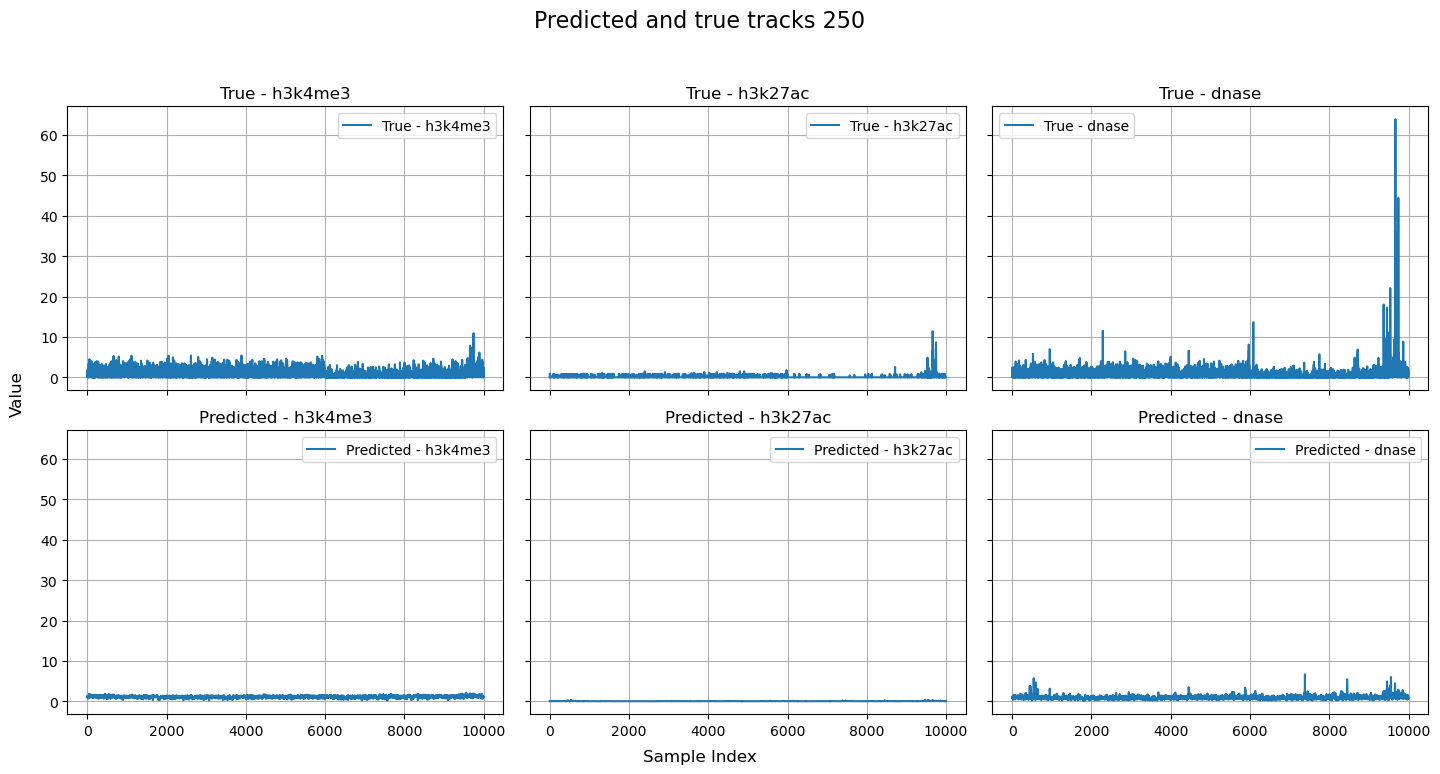

In [23]:
idx = 250
a,b = evals_train.dataset[idx]
out = evals_train(data=a).squeeze()
print(b.shape, out.shape)

pred = out.detach().cpu().numpy()
true = b.numpy()

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)

row_titles = ['True', 'Predicted']
col_titles = ['h3k4me3', 'h3k27ac', 'dnase']

# Populate the subplots
for row, data in enumerate([true, pred]):
    for col in range(3):
        ax = axes[row, col]
        ax.plot(data[:, col], label=f'{row_titles[row]} - {col_titles[col]}')
        ax.set_title(f'{row_titles[row]} - {col_titles[col]}')
        ax.legend()
        ax.grid(True)

# Add shared labels
fig.suptitle(f'Predicted and true tracks {idx}', fontsize=16)
fig.text(0.5, 0.04, 'Sample Index', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Value', va='center', rotation='vertical', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

# Show the plot
plt.show()

torch.Size([10000, 3]) torch.Size([10000, 3])


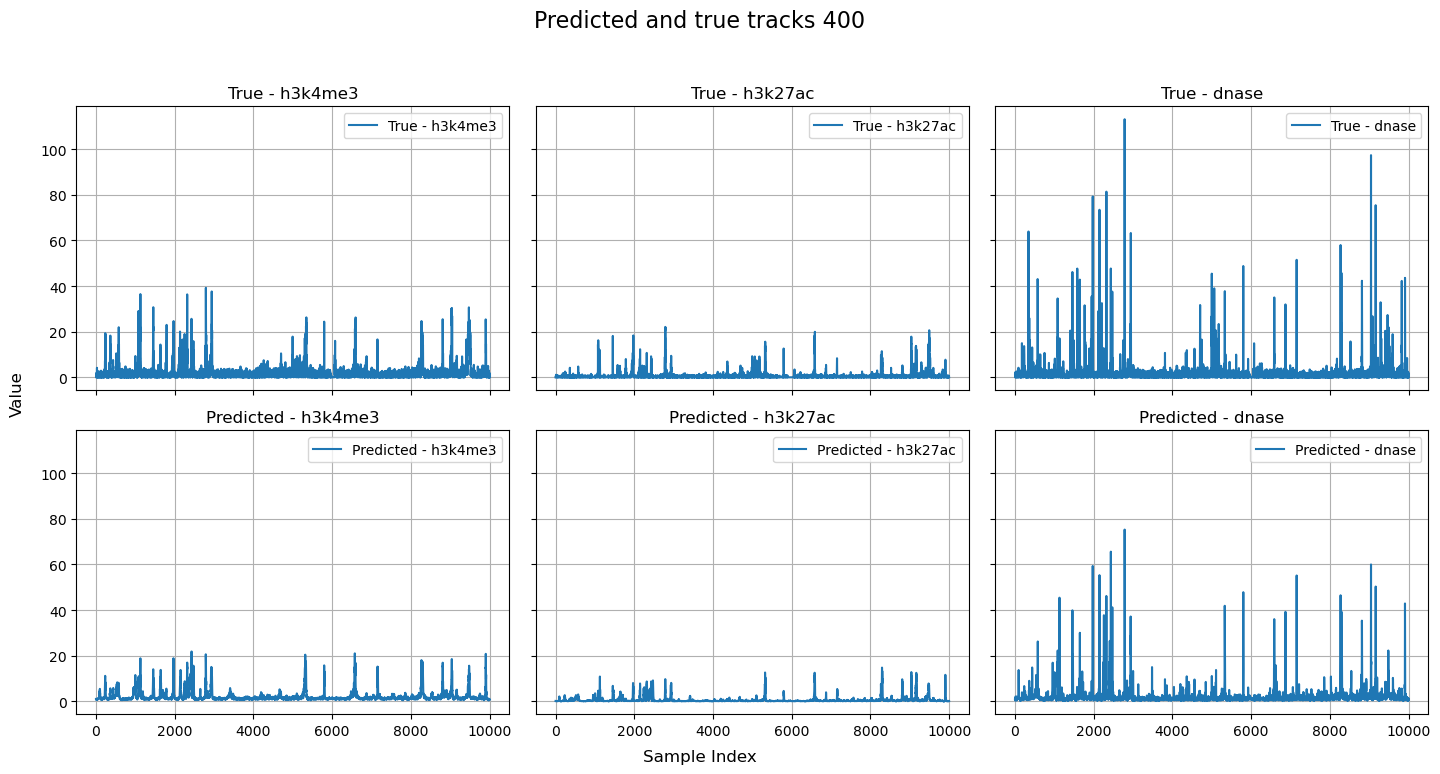

In [24]:
idx = 400
a,b = evals_train.dataset[idx]
out = evals_train(data=a).squeeze()
print(b.shape, out.shape)

pred = out.detach().cpu().numpy()
true = b.numpy()

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)

row_titles = ['True', 'Predicted']
col_titles = ['h3k4me3', 'h3k27ac', 'dnase']

# Populate the subplots
for row, data in enumerate([true, pred]):
    for col in range(3):
        ax = axes[row, col]
        ax.plot(data[:, col], label=f'{row_titles[row]} - {col_titles[col]}')
        ax.set_title(f'{row_titles[row]} - {col_titles[col]}')
        ax.legend()
        ax.grid(True)

# Add shared labels
fig.suptitle(f'Predicted and true tracks {idx}', fontsize=16)
fig.text(0.5, 0.04, 'Sample Index', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'Value', va='center', rotation='vertical', fontsize=12)

# Adjust layout for better spacing
plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])

# Show the plot
plt.show()

In [25]:
len(evals_train.dataset)

6336

In [27]:
import time
start = time.time()
for i in range(len(evals_train.dataset)):
    a,b = evals_train.dataset[i]
print(time.time()-start) #all 6000 examples in 2.5 seconds, I think

2.5656208992004395
